# Small data and deep learning
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction
Assume we are in a context where few "gold" labeled data are available for training, say $\mathcal{X}_{\text{train}}\triangleq\{(x_n,y_n)\}_{n\leq N_{\text{train}}}$, where $N_{\text{train}}$ is small. A large test set $\mathcal{X}_{\text{test}}$ is available. A large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question:

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset)

In your final report, please keep the logs of each training procedure you used. We will only run this jupyter if we have some doubts on your implementation. 

__The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.__


You can use https://colab.research.google.com/ to run your experiments.

In [1]:
import os
import glob
from google.colab import drive

## load train, test and validation label arrays
drive = drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Training set creation
__Question 1 (2 points):__ Propose a dataloader or modify the file located at https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py in order to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set. 

In [97]:
transform_train = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])

transform_test = transforms.Compose([
    transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)


Files already downloaded and verified
Files already downloaded and verified


In [98]:
#https://www.cnblogs.com/marsggbo/p/10496696.html 
from torch.utils.data.sampler import SubsetRandomSampler,SequentialSampler,BatchSampler
indices=list(range(len(trainset)))
first100 = torch.utils.data.Subset(trainset,list(range(0,100)))
train_batch_dataloader = torch.utils.data.DataLoader(first100,batch_size=5,drop_last=False,shuffle=True)#
X_dataloader = torch.utils.data.DataLoader(trainset,sampler=SequentialSampler(indices[100:]),batch_size=20,drop_last=False,shuffle=False)
val_batch_dataloader = torch.utils.data.DataLoader(testset,batch_size=5,drop_last=False,shuffle=False)

In [ ]:
# https://zhuanlan.zhihu.com/p/30934236
#主要讲的是dataloader和dataset的区别，dataset可以用get item/lenth GET tensor的具体数据/datset的整体长度
#dataloader 主要用于对数据集进行各种取样，batch，返回的是个iter

This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. The remaining samples correspond to $\mathcal{X}$. The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (1.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

**#### The difficulty to evaluate the training procedures can be caused by many aspects.**

1. The difficulty from the explainability

    (1) Difficulty: We can directly see the accuracy score of the model. However, we can't directly see the black box in the hidden layers, for example what features do they learn and do they learn the correct features？ In some cases, even though the accuracy score is satisfying, the training procedure can be a totally mess.
    
    (2) Solutions: To solve this problem, we can use CAM and Grad-CAM to diaplay the heatmap to locate the key areas on which the network makes the decision to see if they catch the correct features. We can also visualize the filters in each layer and see what features has learnt by them.


2. The difficulty from the dataset

    (1) Difficulty: If there are noises from the data, it will consufe our evaluation of the training. ① The small amount of data will cause the over fitting and under fitting. ② The different distribution of the trainset and testset will confuse the evaluation. ③ The similarity of the trainset and testset can also influence our measurement of the training procedure. Especially in this assignment, we have an extremly small amount of data and they are not sampled randomly.
    (2) Soltion: To solve these problems, we can get more data, split them randomly and in same distribution to make sure the data in good quality. Besides, we can introduce transfer learning such as data augmentation, pre-trained model, weak supervise, incorporating a priori to reduce the influence from the dataset.


3. The difficulty from the property of models
    (1) Difficulty: The randomness and unstability of the neural network. The deeplearing netwrok will set random initial weight and randomly shuffle the data in each training period. So we will get different results everytime. 
    (2) Soltion: To solve this problem, we can set a seed to gain same inital weight.
    


# Raw approach: the baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate schedule, i.e. how to decrease the learning rate as a function of the number of epochs. A possible schedule is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the laerning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper: http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. Obviously, it is a different context for those researchers who had access to GPUs.

## ResNet architectures

__Question 3 (4 points):__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint:* You can re-use the following code: https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

In [6]:
import torch.nn as nn
import torch.nn.functional as F
class BasicBlock(nn.Module):
  expansion = 1

  def __init__(self, in_channel, out_channel, stride=1):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=out_channel, kernel_size=3, stride=stride, padding=1, bias=False)#stride=stride make 像素进一步减半
    self.bn1 = nn.BatchNorm2d(out_channel)
    self.relu = nn.ReLU()
    self.conv2 = nn.Conv2d(in_channels=out_channel, out_channels=out_channel, kernel_size=3, stride=1, padding=1, bias=False)#但此处的是保持像素的
    self.bn2 = nn.BatchNorm2d(out_channel)
    self.shortcut = nn.Sequential()
    if stride != 1 or in_channel != self.expansion*out_channel:
        self.shortcut = nn.Sequential(nn.Conv2d(in_channel, self.expansion*out_channel ,kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*out_channel)
            ) # in case intermediate layer does not match the channel size

  def forward(self, x): #forward of one basic block 
    
    out = self.relu(self.bn1(self.conv1(x)))

    out = self.bn2(self.conv2(out))

    out += self.shortcut(x)
    out = self.relu(out) #as relu is after the PLUS action.

    return out

class ResNet(nn.Module):
  def __init__(self, block, blocks_num, num_classes=10): 
    # block is in [basicblock ,bottleneck];
    # blocks_num is [2,2,2,2] for 18-layer; [3,4,6,3]for 34-layer;
    super(ResNet, self).__init__()
    self.in_channel = 64

    self.conv1 = nn.Conv2d(3, self.in_channel, 3, stride=1, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(self.in_channel)#here we can write in_channel or 64 since it is used only once,the other batch norms are defined within the block.
    self.relu = nn.ReLU(inplace=True)
    #self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
    self.layer1 = self._make_layer(block, 64, blocks_num[0]) #数字是：#input channels
    self.layer2 = self._make_layer(block, 128, blocks_num[1], stride=2)#stride=2 since we need to make h&w=output
    self.layer3 = self._make_layer(block, 256, blocks_num[2], stride=2)
    self.layer4 = self._make_layer(block, 512, blocks_num[3], stride=2)
   
    self.fc = nn.Linear(512*block.expansion, num_classes) #output
 #   for m in self.modules():
  #    if isinstance(m, nn.Conv2d):
   #     nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')'''
  
  def _make_layer(self, block, channel, block_num, stride=1):
    
    layers = []
    layers.append(block(self.in_channel, channel,stride=stride)) #here we use what we defined for block
    #if downsample=none, then it was just a block without conv for x.
    self.in_channel = channel*block.expansion

    for _ in range(1, block_num): #block_num:[3,4,6，3] for resnet-34
      layers.append(block(self.in_channel, channel)) #since only the first layer in the block needing changement of stride,the others all have stride=1
    return nn.Sequential(*layers)

  def forward(self, x):
    x=self.relu(self.bn1(self.conv1(x)))

    x=self.layer1(x)
    x=self.layer2(x)
    x=self.layer3(x)
    x=self.layer4(x)

   
    x = F.avg_pool2d(x, 4)
    x = torch.flatten(x,1)
    x = self.fc(x)
    return x

def resnet18(num_classes=10, include_top=True):
  return ResNet(BasicBlock, [2,2,2,2], num_classes=num_classes)


In [ ]:
!pip install torchnet
import torchnet as tnt

# define confusion matrix using tnt package
confusion_matrix = tnt.meter.ConfusionMeter(10)

In [8]:
import matplotlib.pyplot as plt
# create a function that creates train-val loss graph and saves the figure in a destination folder
def save_graph(train_loss, val_loss, nb_epochs):
    plt.plot(list(range(nb_epochs+1))[1:], train_loss)
    plt.plot(list(range(nb_epochs+1))[1:], val_loss)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

In [99]:
from torch.optim import lr_scheduler
model = resnet18().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, weight_decay=5e-4)#, momentum=0.9, weight_decay=5e-4
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()
epochs = 30

Train (epoch 0/30) [0/20 (0%)]	Loss: 2.385427
Train (epoch 0/30) [5/20 (25%)]	Loss: 2.755600
Train (epoch 0/30) [10/20 (50%)]	Loss: 2.658655
Train (epoch 0/30) [15/20 (75%)]	Loss: 2.375797
Confusion Matrix:
[[   0   81    0    0  919    0    0    0    0    0]
 [   0   14    0    0  986    0    0    0    0    0]
 [   0   18    0    0  982    0    0    0    0    0]
 [   0    4    0    0  996    0    0    0    0    0]
 [   0    2    0    0  998    0    0    0    0    0]
 [   0    6    0    0  994    0    0    0    0    0]
 [   0    0    0    0 1000    0    0    0    0    0]
 [   0    6    0    0  994    0    0    0    0    0]
 [   0   18    0    0  982    0    0    0    0    0]
 [   0    7    0    0  993    0    0    0    0    0]]
TRAIN_LOSS:  2.470 TRAIN_ACC:  13.000
VAL_LOSS:  2.505 VAL_ACC:  10.120
Train (epoch 1/30) [0/20 (0%)]	Loss: 2.240103
Train (epoch 1/30) [5/20 (25%)]	Loss: 2.467144
Train (epoch 1/30) [10/20 (50%)]	Loss: 1.637054
Train (epoch 1/30) [15/20 (75%)]	Loss: 1.983783
C

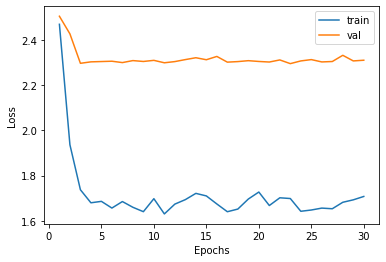

In [100]:
import numpy as np
save_folder = 'drive/My Drive/ADL'
total_train_losses = []
total_val_losses = []

for epoch in range(epochs): # loop over the dataset multiple times
    model.train()
    train_losses = []
    confusion_matrix.reset()
    for i, data in enumerate(train_batch_dataloader): 
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model(inputs)
        loss = criterion(output, labels)
        loss.backward()        
        optimizer.step()
        scheduler.step()
        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), labels.long())
        # print statistics
        if i % 5 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_batch_dataloader),100.*i/len(train_batch_dataloader), loss.item()))

    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    confusion_matrix.reset()

     ##VALIDATION##
    with torch.no_grad():
      model.eval()
      val_losses = []

      for i, data in enumerate(val_batch_dataloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs=model(inputs)
          loss=criterion(outputs, labels)
          val_losses.append(loss.item())

          confusion_matrix.add(outputs.data.squeeze(), labels)
          val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)

    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()
    #write_results(ff, save_folder, epoch, train_acc, val_acc, train_loss_mean, val_loss_mean)

    torch.save(model.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs)



From Scratch:

---


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18 | 30(best test acc got on epoch=18) | 40.00 | 17.67 |

---
Accuracy for the whole dataset:


*   link:https://github.com/kuangliu/pytorch-cifar

---
| Model |  accuracy | 
|------|------
|   Resnet18 |93.02  |



# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on: https://pytorch.org/docs/stable/torchvision/models.html.

__Question 4 (3 points):__ Pick a model from the list above, adapt it for CIFAR and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

In [78]:
def train_model(model, criterion, optimizer, num_epochs=30):
    since = time.time()
    model.train()
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data.
        for inputs, labels in train_batch_dataloader: 
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
           
        epoch_loss = running_loss / 100
        epoch_acc = running_corrects.double() / 100

        print('Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    print('Time for training is {}'.format(time.time()-since))

--------------------------------------------------------DenseNet121-----------------------------------------------------------------

In [81]:
# Densenet121
import torch.optim as optim
import time
import copy
model_conv = torchvision.models.densenet121(pretrained=True).to(device)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

In [82]:
train_model(model_conv, criterion, optimizer_conv, num_epochs=30)

Epoch 1/30
----------
Loss: 2.3300 Acc: 0.1200
Epoch 2/30
----------
Loss: 2.3024 Acc: 0.1700
Epoch 3/30
----------
Loss: 2.0590 Acc: 0.2400
Epoch 4/30
----------
Loss: 1.9876 Acc: 0.3000
Epoch 5/30
----------
Loss: 1.8210 Acc: 0.3600
Epoch 6/30
----------
Loss: 1.8457 Acc: 0.3400
Epoch 7/30
----------
Loss: 1.7019 Acc: 0.3900
Epoch 8/30
----------
Loss: 1.7176 Acc: 0.4300
Epoch 9/30
----------
Loss: 1.6580 Acc: 0.4700
Epoch 10/30
----------
Loss: 1.5837 Acc: 0.4900
Epoch 11/30
----------
Loss: 1.3281 Acc: 0.5800
Epoch 12/30
----------
Loss: 1.4148 Acc: 0.5700
Epoch 13/30
----------
Loss: 1.5563 Acc: 0.4800
Epoch 14/30
----------
Loss: 1.2131 Acc: 0.6200
Epoch 15/30
----------
Loss: 1.3908 Acc: 0.5300
Epoch 16/30
----------
Loss: 1.5788 Acc: 0.4400
Epoch 17/30
----------
Loss: 1.3897 Acc: 0.5400
Epoch 18/30
----------
Loss: 1.4053 Acc: 0.5400
Epoch 19/30
----------
Loss: 1.2621 Acc: 0.5500
Epoch 20/30
----------
Loss: 1.2389 Acc: 0.6200
Epoch 21/30
----------
Loss: 1.3441 Acc: 0.5700
E

In [83]:
model_conv.eval()
start = time.time()
with torch.no_grad():
    corrects = 0.0
    for images, labels in val_batch_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_conv(images)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

print('Test accuracy is {}'.format(100 * corrects.double() / len(testset)))        
print('Time for test is {}'.format(time.time()-start))

Test accuracy is 21.540000000000003
Time for test is 31.25330114364624


----------------------------------------------DenseNet121 + Same preprocess---------------------------------------------------

In [86]:
from torchvision import datasets, transforms

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
sample = list(range(0,100))
subset = torch.utils.data.Subset(trainset,sample)
train_batch_dataloader = torch.utils.data.DataLoader(subset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_batch_dataloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [89]:
# Densenet121
model_conv = torchvision.models.densenet121(pretrained=True).to(device)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.classifier.in_features
model_conv.classifier = nn.Linear(num_ftrs, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(model_conv.classifier.parameters(), lr=0.001, momentum=0.9)

In [90]:
train_model(model_conv, criterion, optimizer_conv,num_epochs=30)

Epoch 1/30
----------
Loss: 2.3523 Acc: 0.1200
Epoch 2/30
----------
Loss: 2.3117 Acc: 0.2100
Epoch 3/30
----------
Loss: 2.1713 Acc: 0.2400
Epoch 4/30
----------
Loss: 1.9603 Acc: 0.2900
Epoch 5/30
----------
Loss: 2.0326 Acc: 0.3300
Epoch 6/30
----------
Loss: 1.9665 Acc: 0.3500
Epoch 7/30
----------
Loss: 1.8633 Acc: 0.3300
Epoch 8/30
----------
Loss: 1.8232 Acc: 0.4000
Epoch 9/30
----------
Loss: 1.7936 Acc: 0.3300
Epoch 10/30
----------
Loss: 1.8154 Acc: 0.4000
Epoch 11/30
----------
Loss: 1.7146 Acc: 0.4300
Epoch 12/30
----------
Loss: 1.7153 Acc: 0.3600
Epoch 13/30
----------
Loss: 1.7479 Acc: 0.4200
Epoch 14/30
----------
Loss: 1.5621 Acc: 0.4900
Epoch 15/30
----------
Loss: 1.6656 Acc: 0.4000
Epoch 16/30
----------
Loss: 1.7217 Acc: 0.4100
Epoch 17/30
----------
Loss: 1.4663 Acc: 0.5100
Epoch 18/30
----------
Loss: 1.5564 Acc: 0.4700
Epoch 19/30
----------
Loss: 1.3811 Acc: 0.5200
Epoch 20/30
----------
Loss: 1.4121 Acc: 0.5000
Epoch 21/30
----------
Loss: 1.3911 Acc: 0.5900
E

In [92]:
model_conv.eval()
start = time.time()
with torch.no_grad():
    corrects = 0.0
    for images, labels in test_batch_dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_conv(images)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

print('Test accuracy is {}'.format(100 * corrects.double() / len(testset)))        
print('Time for test is {}'.format(time.time()-start))

Test accuracy is 50.6
Time for test is 54.011399269104004


----------------------------------------------Resnet18 + Same preprocess---------------------------------------------------

In [93]:
from torchvision import datasets, transforms

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
sample = list(range(0,100))
subset = torch.utils.data.Subset(trainset,sample)
train_batch_dataloader = torch.utils.data.DataLoader(subset, batch_size=4, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)
test_batch_dataloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [94]:
# Resnet18
pre_resnet = torchvision.models.resnet18(pretrained=True).to(device)
for param in pre_resnet.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pre_resnet.fc.in_features
pre_resnet.fc = nn.Linear(num_ftrs, 10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer_conv = optim.SGD(pre_resnet.fc.parameters(), lr=0.001, momentum=0.9)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [95]:
train_model(pre_resnet, criterion, optimizer_conv, num_epochs=30)

Epoch 1/30
----------
Loss: 2.5426 Acc: 0.1100
Epoch 2/30
----------
Loss: 2.3251 Acc: 0.1900
Epoch 3/30
----------
Loss: 2.2991 Acc: 0.2300
Epoch 4/30
----------
Loss: 2.1176 Acc: 0.2500
Epoch 5/30
----------
Loss: 1.9982 Acc: 0.3000
Epoch 6/30
----------
Loss: 2.0876 Acc: 0.2500
Epoch 7/30
----------
Loss: 1.9667 Acc: 0.3500
Epoch 8/30
----------
Loss: 1.9093 Acc: 0.3400
Epoch 9/30
----------
Loss: 1.8286 Acc: 0.3100
Epoch 10/30
----------
Loss: 1.6987 Acc: 0.4700
Epoch 11/30
----------
Loss: 1.7230 Acc: 0.5000
Epoch 12/30
----------
Loss: 1.6933 Acc: 0.4200
Epoch 13/30
----------
Loss: 1.6142 Acc: 0.4500
Epoch 14/30
----------
Loss: 1.7159 Acc: 0.4100
Epoch 15/30
----------
Loss: 1.5982 Acc: 0.4700
Epoch 16/30
----------
Loss: 1.6501 Acc: 0.5300
Epoch 17/30
----------
Loss: 1.5845 Acc: 0.5500
Epoch 18/30
----------
Loss: 1.5460 Acc: 0.4400
Epoch 19/30
----------
Loss: 1.6808 Acc: 0.3800
Epoch 20/30
----------
Loss: 1.4145 Acc: 0.5100
Epoch 21/30
----------
Loss: 1.4748 Acc: 0.5200
E

In [96]:
pre_resnet.eval()
start = time.time()
with torch.no_grad():
    corrects = 0.0
    for images, labels in test_batch_dataloader:
        images, labels = images.to(device),labels.to(device)
        outputs = pre_resnet(images)
        _, preds = torch.max(outputs, 1)
        corrects += torch.sum(preds == labels.data)

print('Test accuracy is {}'.format(100 * corrects.double() / len(testset)))        
print('Time for test is {}'.format(time.time()-start))

Test accuracy is 48.17
Time for test is 22.597277641296387


| Model | Number of  epochs  | Train accuracy | Test accuracy | Preprocess |
|------|------|------|------|------|
|   Densenet121  | 30 | 65.00% | 21.54% | different with pre-trained model |
|   Densenet121  | 30 | 54.00% | 50.60% | same with pre-trained model(i.e. with augmentation) |
|   Resnet18  | 30 | 55.00% | 48.17%| same with pre-trained model(i.e. with augmentation) |



# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks. For now, we only consider linear transformations $\mathcal{T}$ of the inputs $x:\mathbb{S}^2\rightarrow\mathbb{R}$ where $\mathbb{S}$ is the support of an image, meaning that:

$$\forall u\in\mathbb{S}^2,\mathcal{T}(\lambda x+\mu y)(u)=\lambda \mathcal{T}(x)(u)+\mu \mathcal{T}(y)(u)\,.$$

For instance if an image had an infinite support, a translation $\mathcal{T}_a$ by $a$ would lead to:

$$\forall u, \mathcal{T}_a(x)(u)=x(u-a)\,.$$

Otherwise, one has to handle several boundary effects.

__Question 5 (1.5 points):__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

**The most common issue in dealing with these data augmentation methods is their safety of application, which refers to its likelihood of preserving the label post-transformation.**


To be specific, 
1. Translations is very  useful in avoiding positional bias in the data, but in some tasks such as medical image analysis, the biases distancing the training data from the testing data are more complex than positional and translational variances.; 
2. Slight rotations could be useful on digit recognition tasks but a huge rotation could harm data auccuracy; 
3. Outward scaling effects might cause lose of image information; 
4. Color changes may discard important color information and thus are not always a label-preserving transformation. For example, when decreasing the pixel values of an image to simulate a darker environment, it may become impossible to see the objects in the image. 

Ideas to tackle these issues are that 

1. Use priori experience to choose reasonable data augmentation methods manually
2. Use data augmentations methods based on Deep Learning such as AutoAugment and RandAugment


Reference: A survey on Image Data Augmentation for Deep Learning (2019)

## Data augmentations

__Question 6 (3 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

In [37]:
import PIL
transform_train_new = transforms.Compose([transforms.RandomCrop(32, padding=4),torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),
    transforms.ToTensor(),transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])


trainset_new = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train_new)
first100 = torch.utils.data.Subset(trainset_new,list(range(0,100)))
train_batch_dataloader_new = torch.utils.data.DataLoader(first100,batch_size=20,drop_last=False,shuffle=True)
#testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
val_batch_dataloader = torch.utils.data.DataLoader(testset,batch_size=20,drop_last=False,shuffle=False)

Files already downloaded and verified


In [40]:
from torch.optim import lr_scheduler
model_2 = resnet18().to(device)
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.01, weight_decay=5e-4) #momentum=0.9,
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
criterion = nn.CrossEntropyLoss()
epochs = 30

Train (epoch 0/30) [0/5 (0%)]	Loss: 2.416271
Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]]
TRAIN_LOSS:  2.369 TRAIN_ACC:  6.000
VAL_LOSS:  2.311 VAL_ACC:  10.000
Train (epoch 1/30) [0/5 (0%)]	Loss: 2.199887
Confusion Matrix:
[[   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    0    0    0 1000    0    0]
 [   0    0    0    0    1    0    0  999    0    0]
 [   0    0    0    0    1    0    0  999    0    0]
 [   0    0    0    0    2    0    0  998    0    0]
 [   0 

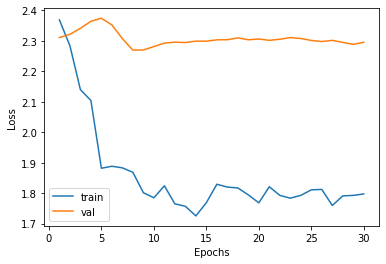

In [41]:
import numpy as np
save_folder = 'drive/My Drive/ADL/DA'
total_train_losses = []
total_val_losses = []

for epoch in range(epochs): # loop over the dataset multiple times
    model_2.train()
    train_losses = []
    confusion_matrix.reset()
    for i, data in enumerate(train_batch_dataloader_new): 
        # get the inputs
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        output = model_2(inputs)
        loss = criterion(output, labels)
        loss.backward()        
        optimizer.step()
        scheduler.step()

        train_losses.append(loss.item())
        confusion_matrix.add(output.data.squeeze(), labels.long())
        # print statistics
        if i % 5 == 0:
            print('Train (epoch {}/{}) [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, epochs, i, len(train_batch_dataloader_new),100.*i/len(train_batch_dataloader_new), loss.item()))

    train_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    train_loss_mean = np.mean(train_losses)
    total_train_losses.append(train_loss_mean)
    confusion_matrix.reset()

     ##VALIDATION##
    with torch.no_grad():
      model_2.eval()
      val_losses = []

      for i, data in enumerate(val_batch_dataloader):
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs=model_2(inputs)
          loss=criterion(outputs, labels)
          val_losses.append(loss.item())

          confusion_matrix.add(outputs.data.squeeze(), labels)
          val_losses.append(loss.item())

    print('Confusion Matrix:')
    print(confusion_matrix.conf)

    val_acc=(np.trace(confusion_matrix.conf)/float(np.ndarray.sum(confusion_matrix.conf))) *100
    val_loss_mean = np.mean(val_losses)
    total_val_losses.append(val_loss_mean)

    print('TRAIN_LOSS: ', '%.3f' % train_loss_mean, 'TRAIN_ACC: ', '%.3f' % train_acc)
    print('VAL_LOSS: ', '%.3f' % val_loss_mean, 'VAL_ACC: ', '%.3f' % val_acc)
    confusion_matrix.reset()

    torch.save(model_2.state_dict(), save_folder + '/model_{}.pt'.format(epoch))

save_graph(total_train_losses, total_val_losses, epochs)



Resnet18 from scratch with data augmentatioon:

---


| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18(with data augmentation) | 30 | 42.00 | 20.03 |


# Conclusions

__Question 7 (5 points):__ Write a short report explaining the pros and the cons of each methods that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

**1.Baseline:Resnet18**

---
Advantage of Resnet(18):


1.   Reducing the effect of Vanishing Gradient Problem
2.   Instead of widen the network, increasing depth of the network results in less extra parameters
3.   Accelerate the speed of training of the deep networks




Disadventage of Resnet(18):
1.   Increased complexity of architecture
2.   Adding skip level connections for which you have take into account the dimensionality between the different layers


**2.Different pretrained model(Dense101 and Resnet18)**

---
Advantages: 
1.   improve the accuracy of the prediction even when using a small amount of training data 
2.   significantly reduce the training time since we only train a part of layers
3.   There are various open source models. They are trained on large datasets and finetuned. And they show good generalization abilities.
4.   The usage of the pre-trained model is easy and flexible, we can adjust it aiming at our objective and dataset.

Disadventages: 
1.   There is a limitation on their applications. In other words, we need to carefully consider how similar our data and task are to those of the pre-trained model. For example, the pre-trained model is trained on the ImageNet dataset, it can learn the features of the specific 1000 classes. Thus, it can be used for the tasks with the similar dataset. However it can't be introduced in an unrelated dataset.
2.   The architucture of the model can't be changed, only light tuning is possible.
3.   There is a limitation on the step of the preprocess since when we use a pre-trained model, we need to keep the preprocessing method same. This idea is well verified by pur experience in this assignment.



**3.Resnet with data augmentation**

---
Advantage of Data augmentation for Neural Network:


1.   Each epoch is trained on the original images that have been changed.In our case, training 30 epochs is equivalent to training 30*100=3000 different images
2.   The addition of images allows the neural network to learn more generalized features



Disadventage of Data augmentation for Neural Network:
1.   A method of data enhancement must be found to fit the dataset.
In our case, the data augmentation of resnet18 is not a big improvement compared to baseline
2.   In some cases, the wrong method of data enhancement can lead to a reduction in accuracy



**4.Semi-supervised model**

---
Advantages:
*  it could self learn the unlabeled large dataset using labeled dataset and 
then put them in the model again and self train to get higher accuracy. 

Disadvantages:
*  The cons are obvious, since semi-supervised has strict hypothesis that labeled train dataset and unlabeled test dataset are supposed to have similar classes distribution, the training process is unstable and need longer time to train the model and have a ideal result. 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   Resnet18 | 30(best test acc got on epoch=18) | 40.00 | 17.67% |
|   Resnet18(pre-trained model[with the same augmentation method as dataset of pretrained model])  | 30 | 55.00% | 48.17%|   
|   Resnet18(with data augmentation) | 30 | 42.00 | 20.03% |
|   Mixmatch | 1000 | xxx | xxx |

# Weak supervision

__Bonus \[open\] question (up to 3 points):__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.

The weakly supervised method that we take is MixMatch, defined in the paper MixMatch: A Holistic Approach to Semi-Supervised Learning(2019). 

MixMatch could be a powerful method in semi-supervised tasks as shown in the paper. MixMatch do do data augmentation to obtain K new data for unlabeled data and input these K new data into the same classifier to get different predicted classification probabilities. Then MixMatch uses an algorithm (Sharpen) to make the average variance of multiple probability distributions smaller, the prediction results more self-consistent, and the system entropy smaller. 

The code is mostly from the github resources: https://github.com/YU1ut/MixMatch-pytorch. We change the labeled and unlabeled train dataset in the python file *cifar10.py* (attached in the files *MixMatch-pytorch*) in order to meet the requirement of train data in this project.

The evaluation results of the whole test dataset is list as follows.

| Model | Number of  epochs  |  Test accuracy within Number of  epochs|
|------ |--------------------|------|
| MixMatch | 10 | 36.88 |
| MixMatch | 100 | 45.68| 
| MixMatch | 400 | 55.49 |
| MixMatch | 1000 |  | 

In our training process, the loss decrease and accuracy improvement is unstable (for more details, please check the *log.txt* in the files *MixMatch-pytorch*.). One possible reason is that the data distribution of the first 100 sampels are not dentical with the whole test dataset, which could be a basic hypothesis of semi-supervised algorithms. Besides, to have a ideal accuracy in test dataset as in the paper and github, we need to run the model for more than 1000 epochs and it's quite time-consuming. 

Therefore, we conclude the well-designed dataset with balanced distribution between train dataset and test dataset and a long training time is required if we want to have a higher accuracy, ideally 70-80% in test dataset.